In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_9261/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import csv
import collections
import sys
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.transforms as transforms

from PIL import Image

In [3]:
sys.path.append('../')

from utils.dataset import img_float2int, feature_names, label_names

from utils.transformations import SimCLR_augmentation
from utils.transformations import Astro_augmentation
from utils.transformations import Jitter_astro
from utils.transformations import Jitter_simclr
from utils.transformations import Crop_astro
from utils.transformations import Crop_simclr
from utils.transformations import Rotation
from utils.transformations import Gaussian_blur
from utils.transformations import Resize_img

# Función que explora el dataset

In [4]:
# Print the type of the objects inside the input.
def dataset_structure(data, space=''):

    # Iteration along dictionary
    for keys in data:

        # If the object is other dictionary
        if(type(data[keys]) is dict):

            print('{0}-{1}:'.format(space,keys))
            dataset_structure(data[keys], space + '\t')

        else:

            # Type of the object
            type_obj = type(data[keys]).__name__

            # Extracts an example of the elements into the object
            example = data[keys][0]
            type_example = type(example).__name__

            # If the element is an ndarray, its shape is printed
            if(type_example=='ndarray'):
                shape_example = str(np.shape(example))
            else:
                shape_example = 'Non-ndarray'

            # Print the information (length and type) of the structure inside
            # the dictionary
            print("{0}-{1:<10}N={2:<10}Type:{3}".format(space, keys, len(data[keys]), type_obj), end="")
            print("\t-->\tType:{1:<10}Shape:{2:<10}".format(space, type_example, shape_example))

# Función que grafica las stamps

In [5]:
def stamps_plot(data, type_set, index):
    
    # Loads source's data
    label = data['Train']['labels'][index]
    features = data['Train']['features'][index]
    img = data['Train']['images'][index]
    
    # Prints image's label
    print("Label: {0}".format(label_names[label]))
    
    # Dataframe with features
    d = {'Feature': feature_names, 'Value': features}
    df = pd.DataFrame(data=d)
    
    # Plot of science, reference and difference images
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,15))
    
    ax1.set_title("Science")
    ax1.imshow(img[:,:,0])
    ax1.axis('off')
    
    ax2.set_title("Reference")
    ax2.imshow(img[:,:,1])
    ax2.axis('off')
    
    ax3.set_title("Difference")
    ax3.imshow(img[:,:,2])
    ax3.axis('off')
    
    # Displays images and features
    plt.show()
    #display(df)

# Estructura del dataset

In [6]:
# Dataset is loaded
with open('../dataset/td_ztf_stamp_17_06_20.pkl', 'rb') as f:
    data = pickle.load(f)

# Inner structure of dataset
dataset_structure(data)

-Train:
	-images    N=72710     Type:ndarray	-->	Type:ndarray   Shape:(63, 63, 3)
	-labels    N=72710     Type:ndarray	-->	Type:int64     Shape:Non-ndarray
	-features  N=72710     Type:ndarray	-->	Type:ndarray   Shape:(26,)     
-Validation:
	-images    N=500       Type:ndarray	-->	Type:ndarray   Shape:(63, 63, 3)
	-labels    N=500       Type:ndarray	-->	Type:int64     Shape:Non-ndarray
	-features  N=500       Type:ndarray	-->	Type:ndarray   Shape:(26,)     
-Test:
	-images    N=500       Type:ndarray	-->	Type:ndarray   Shape:(63, 63, 3)
	-labels    N=500       Type:ndarray	-->	Type:int64     Shape:Non-ndarray
	-features  N=500       Type:ndarray	-->	Type:ndarray   Shape:(26,)     


# Cantidad de muestras por clase

In [7]:
# Number of elements of each class

counter_train = collections.Counter(data['Train']['labels'])
counter_validation = collections.Counter(data['Validation']['labels'])
counter_test = collections.Counter(data['Test']['labels'])

print('Train:')
for key, value in counter_train.items():
    print(f'\t{key}:{value}')
    
print('Validation:')
for key, value in counter_validation.items():
    print(f'\t{key}:{value}')

print('Test:')
for key, value in counter_test.items():
    print(f'\t{key}:{value}')

Train:
	2:14542
	0:14542
	1:14542
	4:14542
	3:14542
Validation:
	0:100
	1:100
	2:100
	3:100
	4:100
Test:
	0:100
	1:100
	2:100
	3:100
	4:100


Label: Asteroid


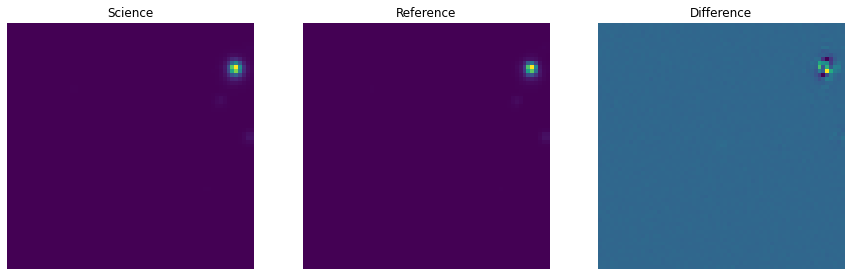

In [8]:
stamps_plot(data, 'Train', 12)

Label: Bogus


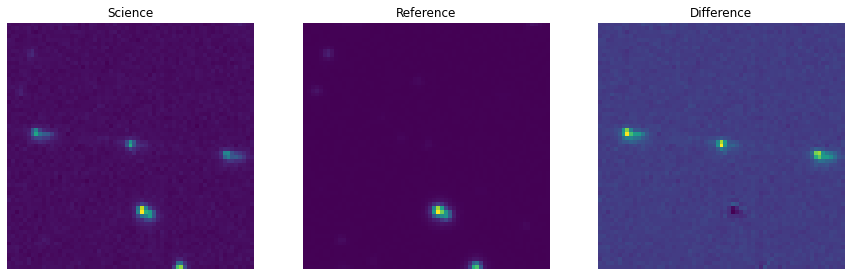

In [9]:
stamps_plot(data, 'Train', 11)

Label: AGN


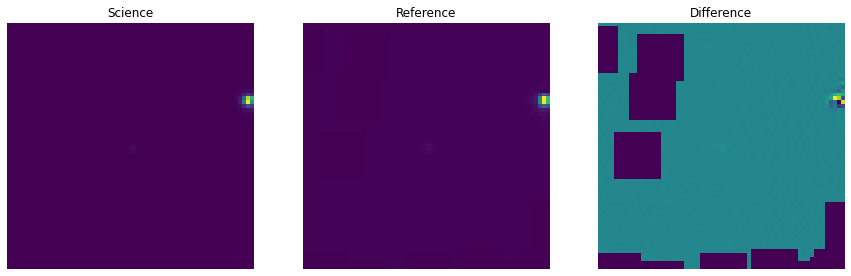

In [10]:
stamps_plot(data, 'Train', 17)

Label: VS


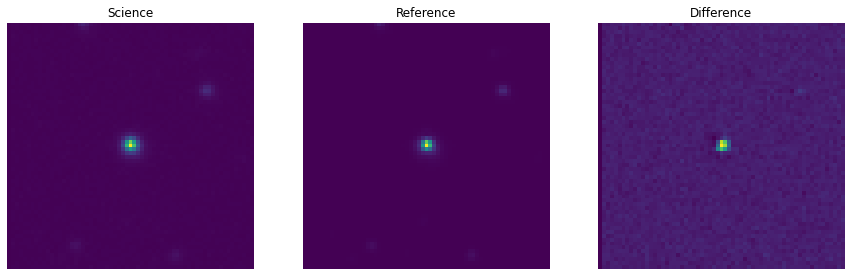

In [11]:
stamps_plot(data, 'Train', 125)

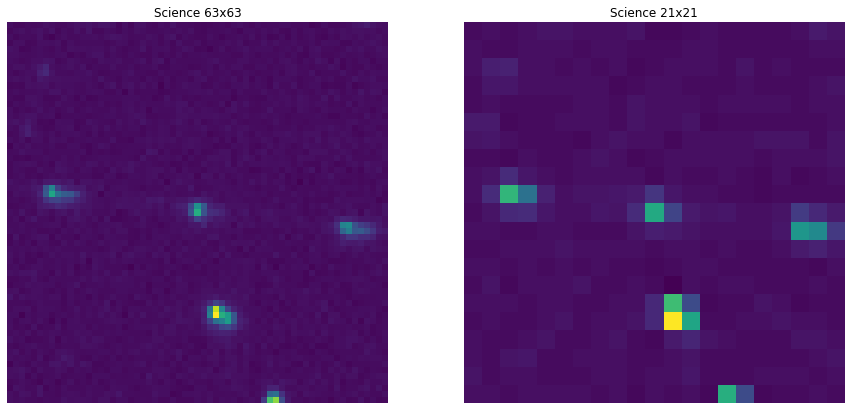

In [12]:
# Example of image resizing 

# Load image
index = 11
img = data['Train']['images'][index][:,:,0]

# New size
size = (21,21)

# Escalation from (0,1) to (0, 255)
img_255 = img_float2int(img)

# Resize
img_PIL = Image.fromarray(img_255)
img_resize = img_PIL.resize(size)

# Plot of science image (63x63 and 21x21)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
    
ax1.set_title("Science 63x63")
ax1.imshow(img)
ax1.axis('off')

ax2.set_title("Science {0}x{1}".format(size[0],size[1]))
ax2.imshow(img_resize)
ax2.axis('off')
plt.show()

# Normalización de features

In [13]:
# Loads source's data
features = data['Train']['features']
print(np.mean(np.array(features, dtype=np.float32), axis=0))
print(np.std(np.array(features, dtype=np.float32), axis=0))

[-0.2873714   0.11175089 -0.03527644 -0.00055827 -0.00971938  0.00157936
  0.5222817   0.0454788   0.02194207 -0.04955371 -0.02466081  0.02335262
 -0.0385435   0.01949287  0.09752761  0.14096506  0.09265201 -0.10308222
  0.02861715  0.00802673 -0.02782944 -0.01558139  0.00917627  0.03677692
  0.33868203  0.2191507 ]
[1.0836236  1.0093966  0.99515635 0.9982329  0.996767   0.994433
 0.91449946 0.9764465  0.90470445 0.964727   1.0097935  0.9968355
 0.9727092  1.0060825  1.0007532  0.9736594  0.95906055 0.9262455
 1.0111927  1.0210558  1.0055873  1.0252767  0.97880936 1.0133779
 1.332348   1.254867  ]


# Augmentation

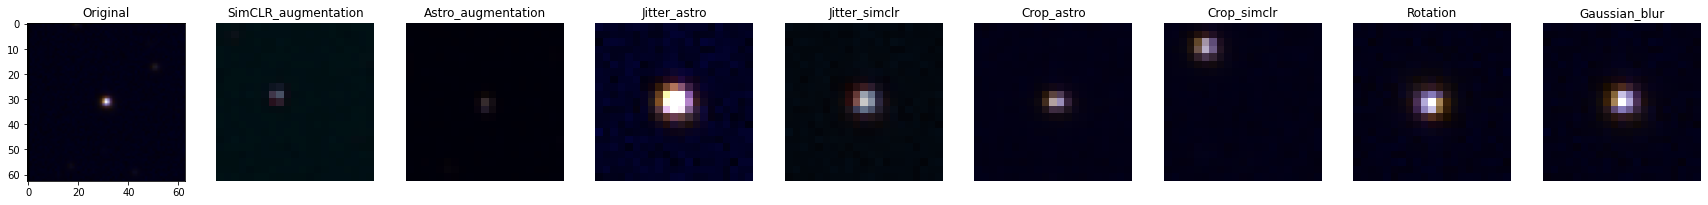

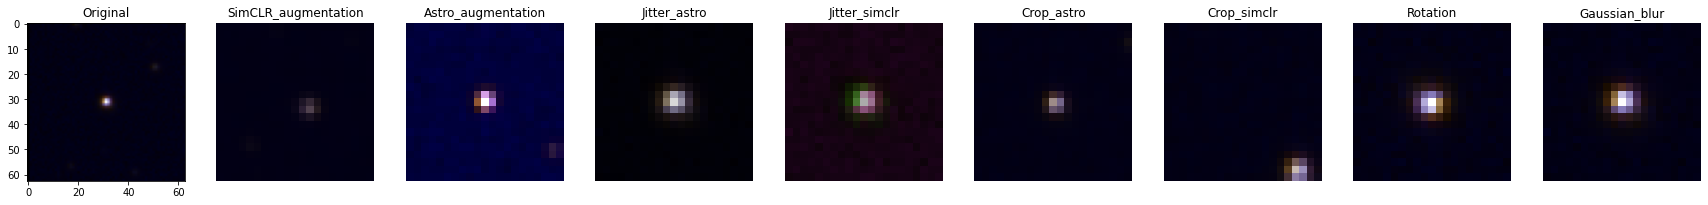

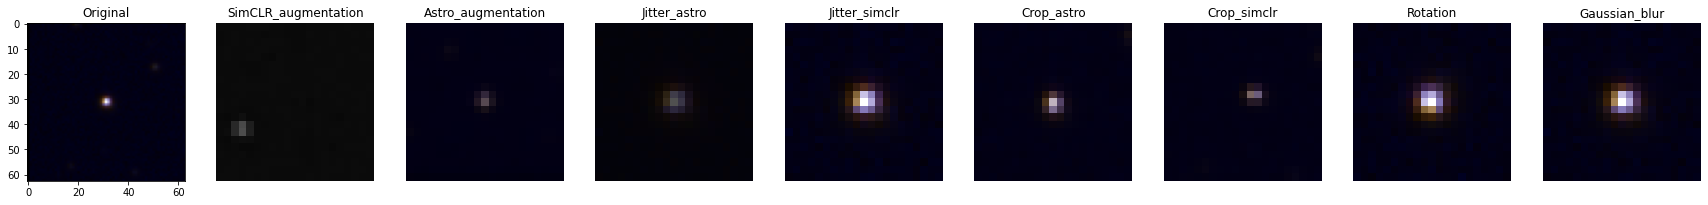

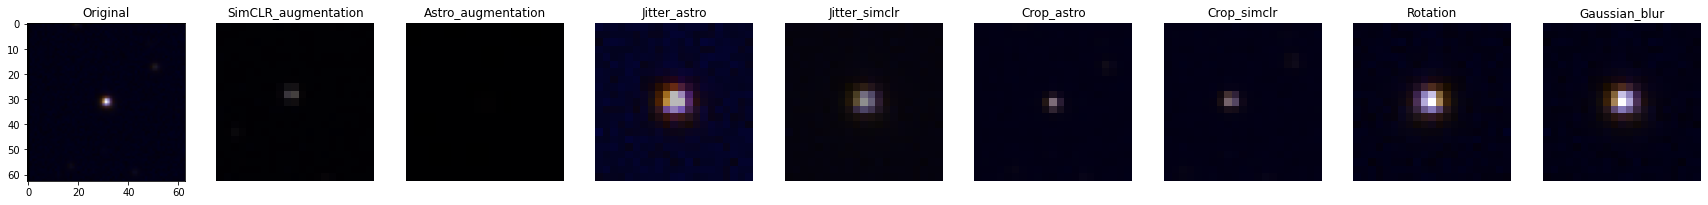

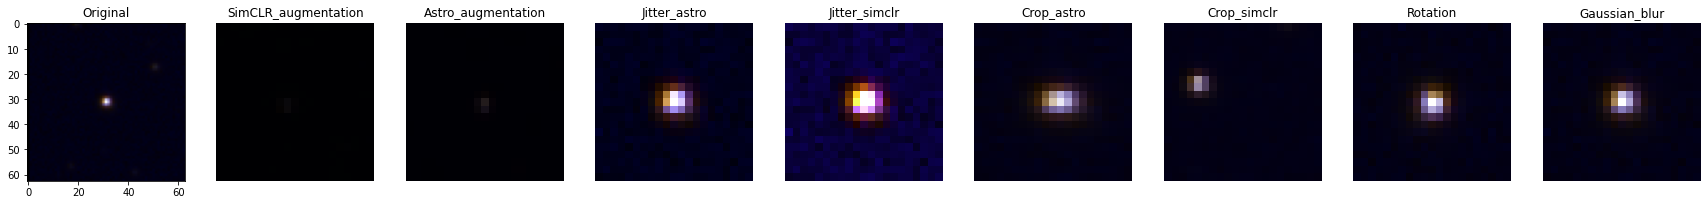

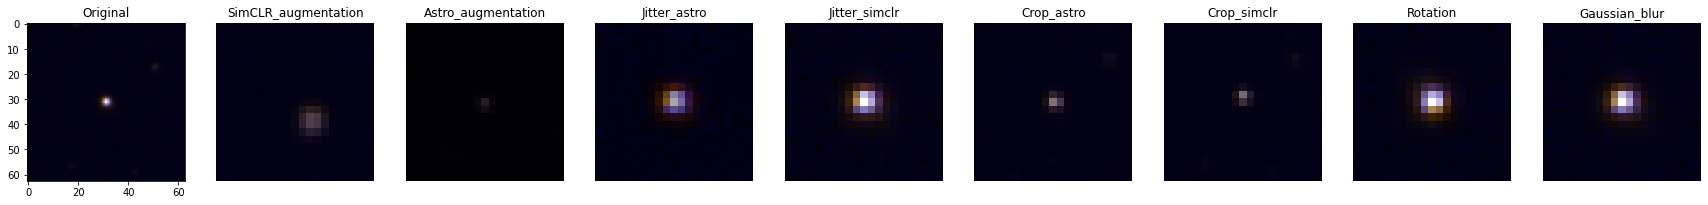

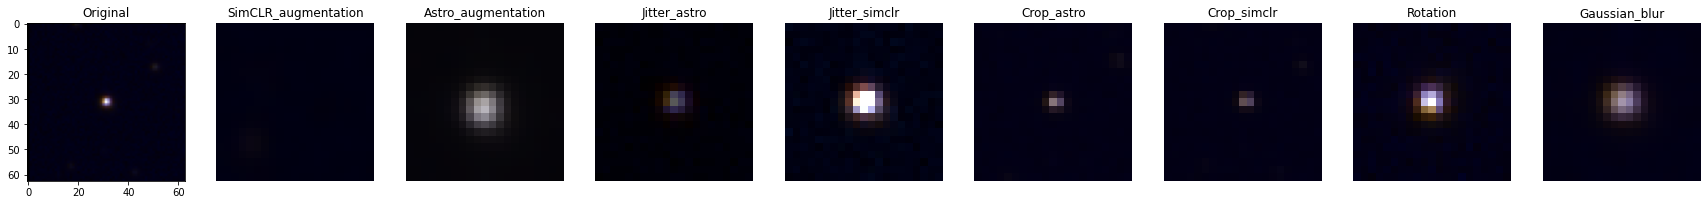

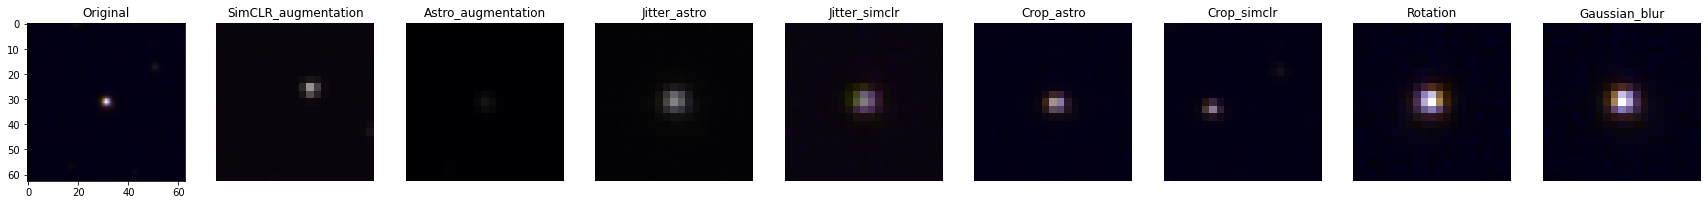

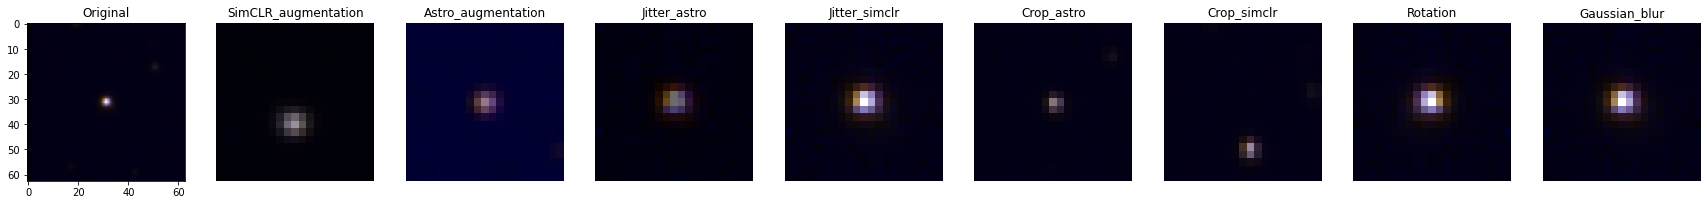

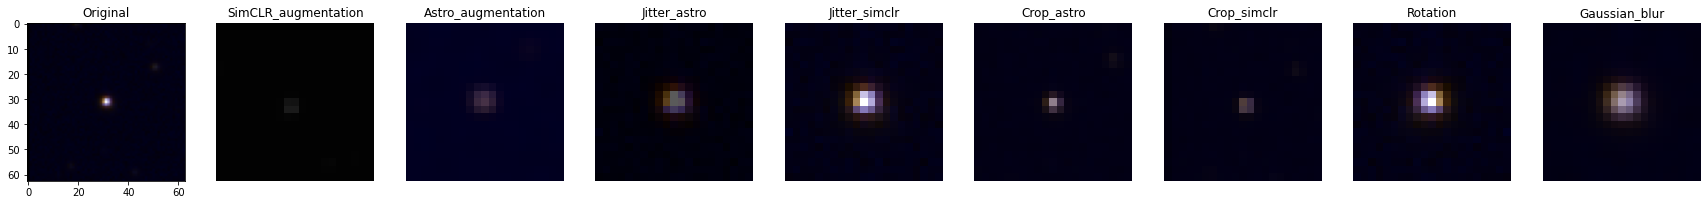

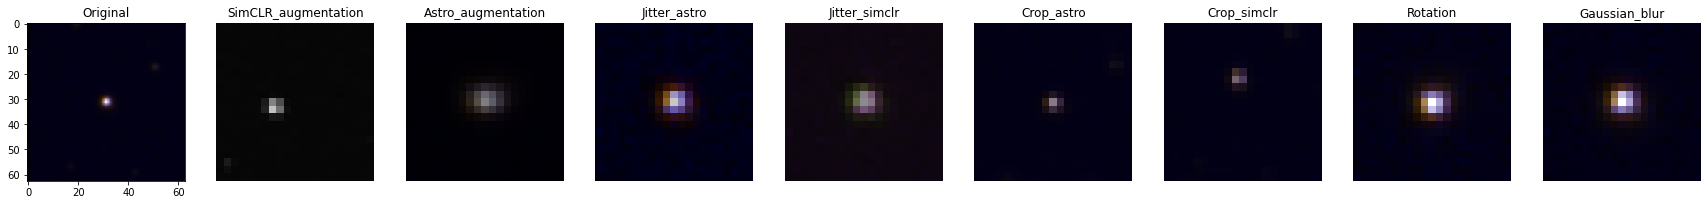

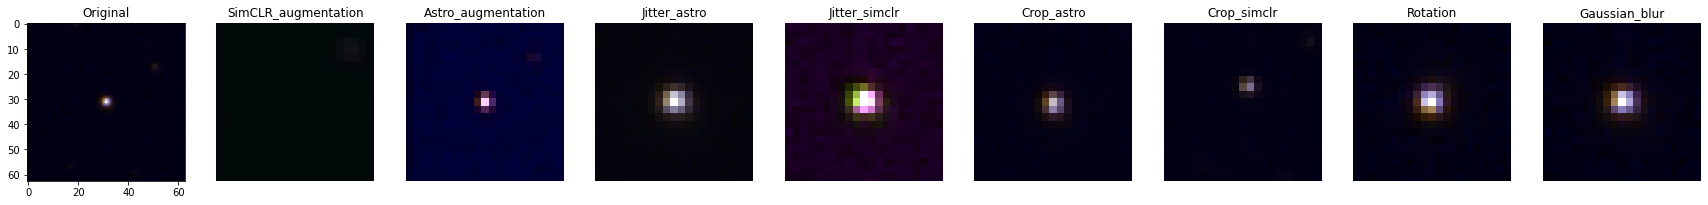

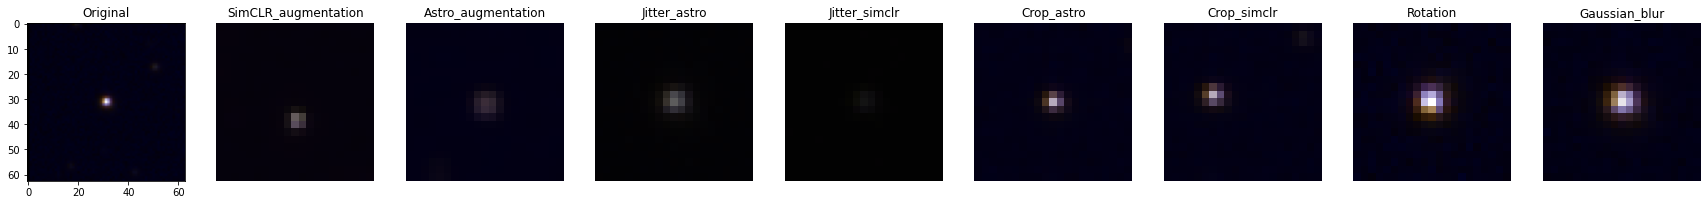

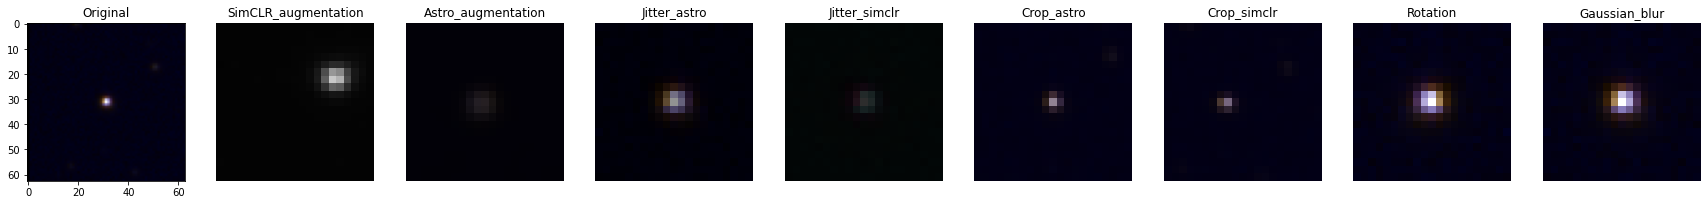

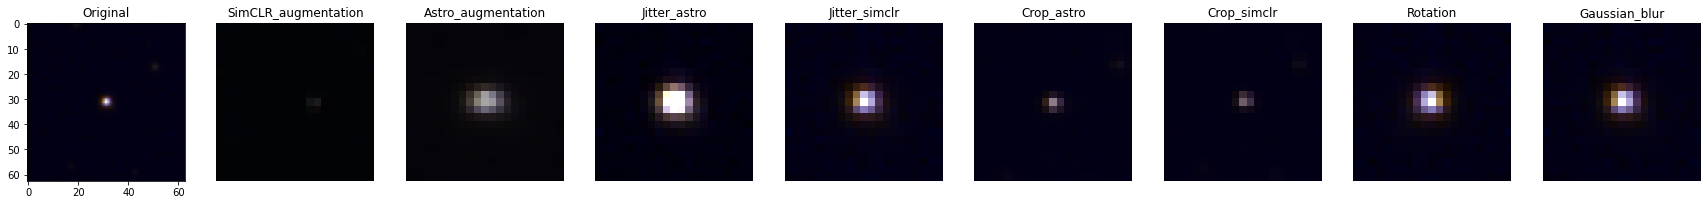

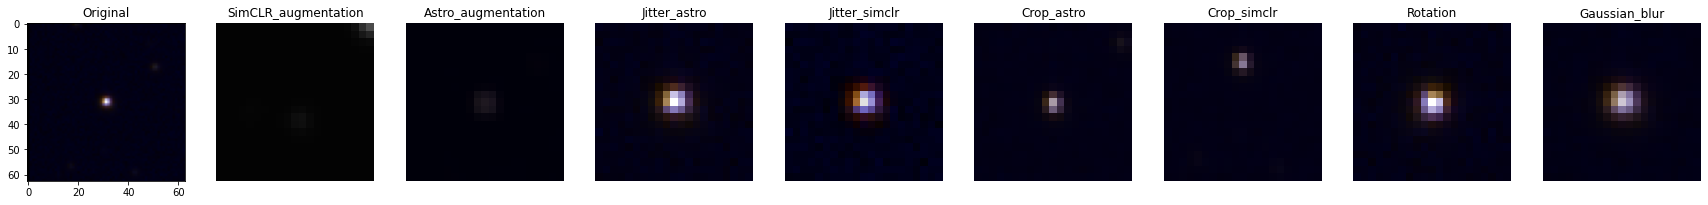

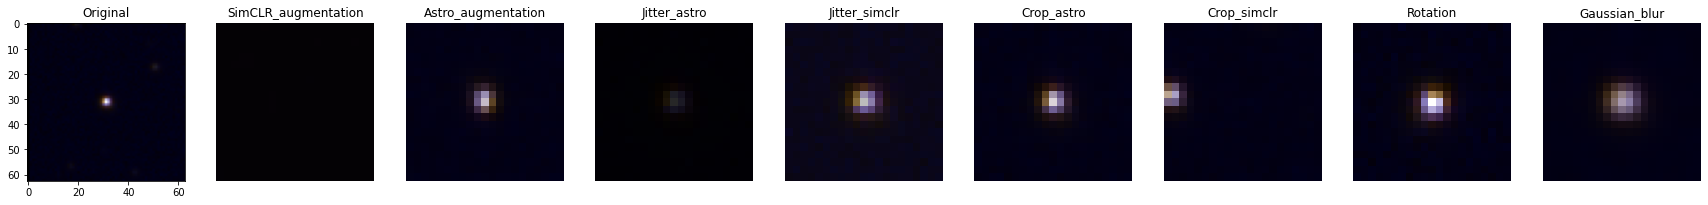

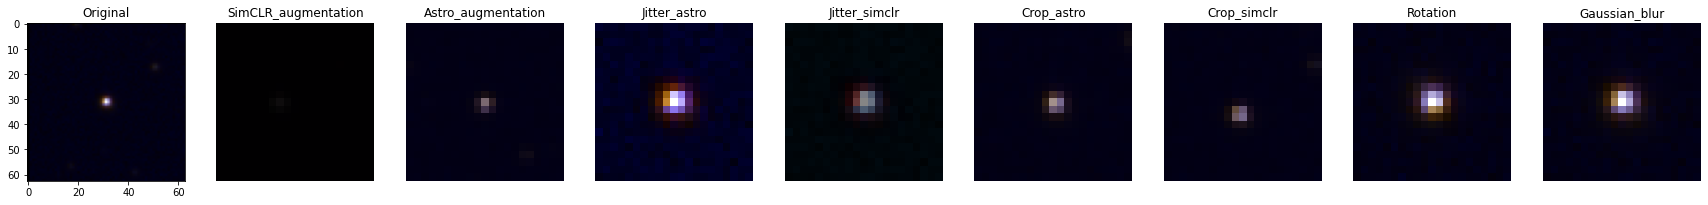

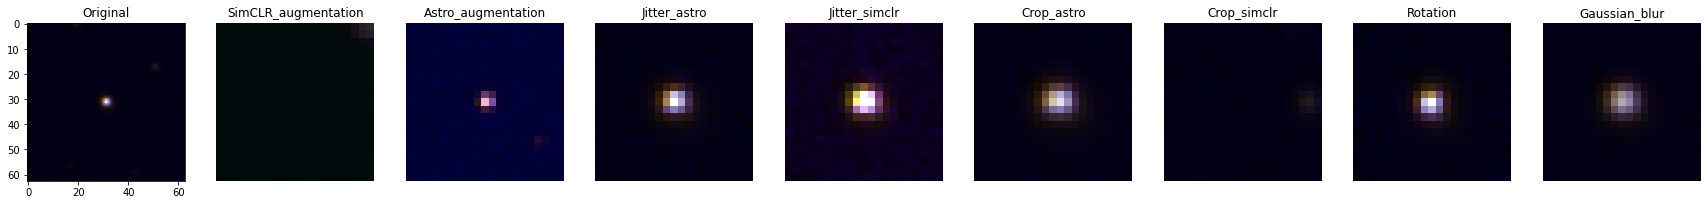

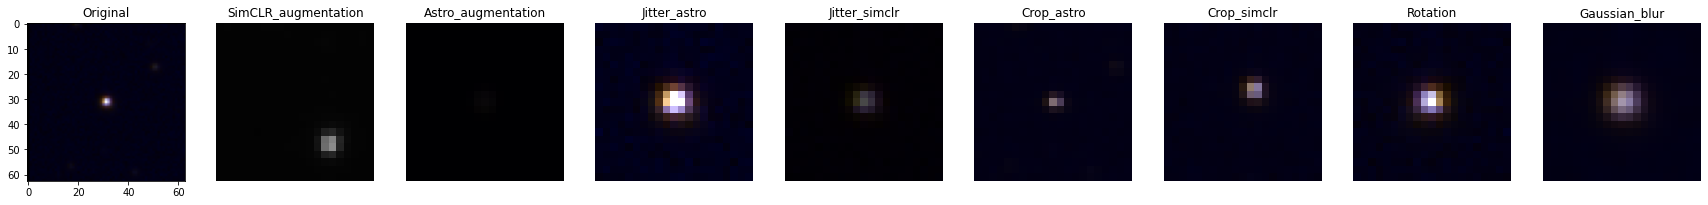

In [15]:
# Load image
index = 125
img = data['Train']['images'][index][:,:,:]

# Image size of augmentations
image_size = 21

# Load augmentation
augmentations = [SimCLR_augmentation(size=image_size),
                 Astro_augmentation(size=image_size),
                 Jitter_astro(size=image_size),
                 Jitter_simclr(size=image_size),
                 Crop_astro(size=image_size),
                 Crop_simclr(size=image_size),
                 Rotation(size=image_size),
                 Gaussian_blur(size=image_size)]

for t in range(20):
    
    #  Initialize plot
    fig, ax = plt.subplots(1, 9, figsize=(30,5))

    ax[0].imshow(img)
    ax[0].set_title('Original')

    for i, augmentation in enumerate(augmentations):
        
        transformation = transforms.Compose([
            transforms.Lambda(img_float2int),
            transforms.ToPILImage(),
            augmentation])
        
        img_t = transformation(img)[0].numpy().transpose(1,2,0)

        ax[i+1].imshow(img_t)
        ax[i+1].set_title(type(augmentation).__name__)
        ax[i+1].axis('off')

    plt.show()